# Importation 

In [18]:
import numpy as np
import glob
import cv2
import os
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage.transform import resize
from skimage import io, color, exposure
from skimage.feature import match_descriptors, plot_matches, SIFT
import random
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Kernels 

In [2]:
## Gaussian
def kernel (x, x1, sigma):
    return np.exp(-(np.linalg.norm(x-x1)**2)/(2*sigma**2))
## Product-based kernel
def kernel_(S1, S2, sigma):
    result = 0.0
    for s in S1:
        for s_prime in S2:
            result += kernel (s, s_prime, sigma)
    result /= np.sqrt(len(S1)) * np.sqrt(len(S2))
    return result
## Normalisation of Kernels
def kernel_norm (x, y, sigma):
    return kernel_(x, y, sigma) / np.sqrt(kernel_(x, x, sigma)*kernel_(y, y, sigma))

# Images representation  

In [3]:
def get_image_gray(img):
    image_gray = rgb2gray(img)  
    return resize(image_gray, (32, 32)) 

def get_image_histo(image): 
    if image.shape[-1] == 4:
        image = color.rgba2rgb(image)
    elif image.shape[-1] == 1:
        image = color.gray2rgb(image)

    # Convertir l'image en float pour effectuer les calculs
    image = image.astype(np.float32)

    # Diviser l'image en canaux de couleur
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    red_hist, _ = np.histogram(red_channel.flatten(), bins=256, range=(0, 255))
    green_hist, _ = np.histogram(green_channel.flatten(), bins=256, range=(0, 255))
    blue_hist, _ = np.histogram(blue_channel.flatten(), bins=256, range=(0, 255))

    # Concaténer les histogrammes en un seul vecteur de caractéristiques
    histogram = np.concatenate((red_hist, green_hist, blue_hist))

    # Normaliser l'histogramme en divisant par le nombre total de pixels
    histogram = histogram / np.sum(histogram)
    return histogram

def sift_discriptor(img):
    img = get_image_gray(img)
    img = cv2.resize(img, (40, 40), interpolation=cv2.INTER_LINEAR)
    descriptor_extractor = SIFT()
    descriptor_extractor.detect_and_extract(img)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    descriptors = descriptors.mean(axis=0, keepdims=True)
    return descriptors.astype(float)

def rgb_to_lab(image):
    # Resize the image to 40x40 while maintaining aspect ratio
    resized_image = cv2.resize(image, (40, 40), interpolation=cv2.INTER_LINEAR)

    # Convert the resized image from RGB to Lab color space
    lab_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2LAB)

    return lab_image

def load_data_from_dir(dir):
    images = []
    images_gray = []
    images_histo = [] 
    sift_discriptors = []
    lab = []
    labels = []
    i = 0
    for file_path in glob.glob(os.path.join(dir, '*.png')):
        if (labels.count(int(file_path.split("\\")[1][0])) < 13):
            img = io.imread(file_path)
            images.append(resize(img, (24, 24)))
            images_gray.append(get_image_gray(img))
            sift_discriptors.append(sift_discriptor(img))
            images_histo.append(get_image_histo(img))
            lab.append(rgb_to_lab(img))
            labels.append(int(file_path.split("\\")[1][0]))
            i += 1
            
            if (i >= 128): break
    return images, images_gray, sift_discriptors, lab, images_histo, labels

# Images Import 

In [4]:
images, images_gray, sift_disc, lab, images_histo, labels = load_data_from_dir('images')
#print(lab)

## Calculate similarity matrix Function
def get_similarite(images, sigma):
    K = np.zeros([len(images), len(images)])
    for i, im_i in enumerate(images):
        for j, im_j in enumerate(images):
            K[i][j] = kernel(im_i, im_j, sigma)
    return K
## Manhattan distance Function 
def manhattan_distance(img1, img2):
    arr1 = np.array(img1)
    arr2 = np.array(img2)
    distance = np.sum(np.abs(arr1 - arr2))
    return distance

In [5]:
random.shuffle(images) ## Images Shuffling
## Update Pi Function
def update_Pi_lsa(K, L, Pi, lambda_val):
    
    l_ind, c_ind = linear_sum_assignment(-K@Pi@L.T)
    max_pi = np.zeros_like(K)
    max_pi[l_ind, c_ind] = 1
    
    updated_pi = (1 - lambda_val) * Pi + lambda_val * max_pi.T
    
    return updated_pi
## Distance mean Function 
def moyenne_distances(K):
    somme_distances = 0.0
    nb_paires_uniques = 0

    for i in range(len(K)):
        for j in range(i + 1, len(K)):
            distance = abs(1 - K[i][j])
            somme_distances += distance
            nb_paires_uniques += 1

    moyenne_distances = somme_distances / nb_paires_uniques
    return moyenne_distances
## Calculate similarity Function
def display_similar_images(images, images_rep, griddata, sigma, lambda_val=0.5):
    K = get_similarite(images_rep, sigma)
    n = len(images)
    Pi = np.eye(n)
    #print("K = \n", K)  
    L = get_similarite(griddata.T, sigma)
    #print("L = \n", L)
    
    for i in range(25000): 
        p = Pi
        Pi = update_Pi_lsa(K, L, Pi, lambda_val) 
        """if np.any(abs(Pi - p) < 1e-10):
            print("VV")
            break""" 
        if i == 25000-1 : Pi = update_Pi_lsa(K, L, Pi, 1)
    data = np.array(images)
    i_sorting = Pi.argmax(axis=1)
    imgdata_sorted = data[i_sorting,]
    return imgdata_sorted, griddata, K
## Displaying Function
def display(imgs, grid):
    fig, ax = plt.subplots()
    for i in range(len(imgs)): 
        imagebox = OffsetImage(imgs[i])
        ab = AnnotationBbox(imagebox, (grid[0, i], grid[1, i]), xycoords='data')
        ax.add_artist(ab)
        ax.axis('off')  
        #ax.annotate(f'({grid[0,i]}, {grid[1,i]})', (grid[0,i], grid[1,i]), xytext=(10, -10), textcoords='offset points')
    ax.set_xlim(0, 4.04)
    ax.set_ylim(0, 1.61)
    current_width, current_height = fig.get_size_inches()
    fig.set_size_inches(current_width+7, current_height)
    plt.subplots_adjust(left=0, right=1.2, bottom=0, top=1.3)
    plt.savefig('AMU.png', orientation ='landscape')
    plt.show()

# Create Grid Of desplaying 

In [19]:
griddata = np.zeros((2,128))
#griddataA[0,] = [1, 1, 1, 1, 2.25, 3.5, 4.75, 4.75, 4.75, 4.75]
#griddataA[1,] = [1, 2.5, 4, 5.5, 4, 2.5, 1, 2.5, 4, 5.5]

In [7]:

#griddata_N[0,] = [1, 1, 1, 1, 1, 1, 1, 1, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 3.5, 3.5, 4.75, 4.75, 6, 6, 7.25, 7.25, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 9,75, 9,75, 9,75, 9,75, 9,75, 9,75, 9,75, 9,75]
#griddata_N[1,] = [1, 1, 1, 1, 1, 1, 1, 1, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 3.5, 3.5, 4.75, 4.75, 6, 6, 7.25, 7.25, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 9,75, 9,75, 9,75, 9,75, 9,75, 9,75, 9,75, 9,75]
def creat_A():
    space_y = .11
    space_x = .11
    max_y = .2 + space_y*7
    griddata_A = np.zeros((2,48))
    tolerance = 1e-6
    for i in range(48):
        if i in range(8):
            griddata_A[0,i] = .2
            if i == 0 : griddata_A[1,i] = .2
            else : griddata_A[1,i] = griddata_A[1,i-1] + space_y
        elif i in range(8, 16):
            griddata_A[0,i] = .2 + space_x
            if i == 8 : griddata_A[1,i] = .2
            else : griddata_A[1,i] = griddata_A[1,i-1] + space_y
        elif i in range(16, 32):
            posX_next = griddata_A[0,15] + space_x
            posY = griddata_A[1,2]
            if i in range(16, 20): 
                griddata_A[0,i] = posX_next
                if i >= 18 : 
                    if griddata_A[1,i-1] == posY + space_y*4 : griddata_A[1,i] = griddata_A[1,i-1] + space_y
                    else : griddata_A[1,i] = posY + space_y*4
                else : 
                    if abs(max_y -  griddata_A[1,i-1]) < tolerance : griddata_A[1,i] = posY 
                    else : griddata_A[1,i] = posY + space_y
            else : posX_next += space_x
            if i in range(20, 24): 
                griddata_A[0,i] = posX_next
                if i >= 22 : 
                    if griddata_A[1,i-1] == posY + space_y*4 : griddata_A[1,i] = griddata_A[1,i-1] + space_y
                    else : griddata_A[1,i] = posY + space_y*4
                else : 
                    if abs(max_y -  griddata_A[1,i-1]) < tolerance : griddata_A[1,i] = posY
                    else : griddata_A[1,i] = posY + space_y
            else : posX_next += space_x
            if i in range(24, 28): 
                griddata_A[0,i] = posX_next
                if i >= 26 : 
                    if griddata_A[1,i-1] == posY + space_y*4 : griddata_A[1,i] = griddata_A[1,i-1] + space_y
                    else : griddata_A[1,i] = posY + space_y*4
                else : 
                    if abs(max_y -  griddata_A[1,i-1]) < tolerance : griddata_A[1,i] = posY 
                    else : griddata_A[1,i] = posY + space_y
            else : posX_next += space_x
            if i in range(28, 32): 
                griddata_A[0,i] = posX_next
                if i >= 30 : 
                    if griddata_A[1,i-1] == posY + space_y*4 : griddata_A[1,i] = griddata_A[1,i-1] + space_y
                    else : griddata_A[1,i] = posY + space_y*4
                else : 
                    if abs(max_y -  griddata_A[1,i-1]) < tolerance : griddata_A[1,i] = posY 
                    else : griddata_A[1,i] = posY + space_y
            else : posX_next += space_x        
        else : 
            if i in range(32, 40) : griddata_A[0,i] = .86
            else : griddata_A[0,i] = .86 + space_x
            if i == 32 or i == 40 : griddata_A[1,i] = .2
            else : griddata_A[1,i] = griddata_A[1,i-1] + space_y
    return griddata_A

griddata_A = creat_A()


print(griddata_A)

[[0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.31 0.31 0.31 0.31 0.31 0.31
  0.31 0.31 0.42 0.42 0.42 0.42 0.53 0.53 0.53 0.53 0.64 0.64 0.64 0.64
  0.75 0.75 0.75 0.75 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.97 0.97
  0.97 0.97 0.97 0.97 0.97 0.97]
 [0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75
  0.86 0.97 0.42 0.53 0.86 0.97 0.42 0.53 0.86 0.97 0.42 0.53 0.86 0.97
  0.42 0.53 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97 0.2  0.31
  0.42 0.53 0.64 0.75 0.86 0.97]]


In [8]:
def creat_M():
    space_y = .11
    space_x = .11
    max_y = .2 + space_y*6
    griddata_M = np.zeros((2,40))
    tolerance = 1e-6
    for i in range(40):
        if i in range(8):
            griddata_M[0,i] = .2
            if i == 0 : griddata_M[1,i] = .2
            else : griddata_M[1,i] = griddata_M[1,i-1] + space_y
        elif i in range(8, 16):
            griddata_M[0,i] = .2 + space_x
            if i == 8 : griddata_M[1,i] = .2
            else : griddata_M[1,i] = griddata_M[1,i-1] + space_y
        elif i in range(16, 24):
            posY = griddata_M[1,i-3]
            if i in range(16, 18): 
                if i >= 17 : 
                    griddata_M[0,i] = griddata_M[0,i-1]
                    griddata_M[1,i] = griddata_M[1,i-3] 
                else : 
                    griddata_M[0,i] = griddata_M[0,i-1] + space_x
                    griddata_M[1,i] = griddata_M[1,i-3] 
            if i in range(18, 20):
                if i >= 19 :
                    griddata_M[0,i] = griddata_M[0,i-1]
                    griddata_M[1,i] = griddata_M[1,i-3]
                else : 
                    griddata_M[0,i] = griddata_M[0,i-1] + space_x
                    griddata_M[1,i] = griddata_M[1,i-2] - space_y
            if i in range(20, 24): 
                if i >= 22 : 
                    if i == 22 : griddata_M[0,i] = griddata_M[0,i-1] + space_x
                    else : griddata_M[0,i] = griddata_M[0,i-1]
                    if griddata_M[1,i-1] == posY : griddata_M[1,i] = griddata_M[1,i-1]
                    else : griddata_M[1,i] = griddata_M[1,i-1] + space_y
                else :
                    if i == 20 : 
                        griddata_M[0,i] = griddata_M[0,i-1] + space_x
                        griddata_M[1,i] = griddata_M[1,i-2]
                    else : 
                        griddata_M[0,i] = griddata_M[0,i-1]
                        griddata_M[1,i] = griddata_M[1,i-2]
        else : 
            if i in range(24, 32) : griddata_M[0,i] = .86
            else : griddata_M[0,i] = .86 + space_x
            if i == 24 or i == 32 : griddata_M[1,i] = .2
            else : griddata_M[1,i] = griddata_M[1,i-1] + space_y
    return griddata_M


griddata_M = creat_M()
griddata_M[0,] += .99
print(griddata_M)

[[1.19 1.19 1.19 1.19 1.19 1.19 1.19 1.19 1.3  1.3  1.3  1.3  1.3  1.3
  1.3  1.3  1.41 1.41 1.52 1.52 1.63 1.63 1.74 1.74 1.85 1.85 1.85 1.85
  1.85 1.85 1.85 1.85 1.96 1.96 1.96 1.96 1.96 1.96 1.96 1.96]
 [0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75
  0.86 0.97 0.75 0.86 0.64 0.75 0.64 0.75 0.75 0.86 0.2  0.31 0.42 0.53
  0.64 0.75 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97]]


In [9]:
def creat_U():
    space_y = .11
    space_x = .11
    max_y = .2 + space_y
    griddata_U = np.zeros((2,40))
    tolerance = 1e-6
    for i in range(40):
        if i in range(8):
            griddata_U[0,i] = .2
            if i == 0 : griddata_U[1,i] = .2
            else : griddata_U[1,i] = griddata_U[1,i-1] + space_y
        elif i in range(8, 16):
            griddata_U[0,i] = .2 + space_x
            if i == 8 : griddata_U[1,i] = .2
            else : griddata_U[1,i] = griddata_U[1,i-1] + space_y
        elif i in range(16, 24):
            posY = griddata_M[1,0]
            if i in range(16, 18): 
                if i >= 17 : 
                    griddata_U[0,i] = griddata_U[0,i-1]
                    griddata_U[1,i] = griddata_U[1,i-1] + space_y
                else : 
                    griddata_U[0,i] = griddata_U[0,i-1] + space_x
                    griddata_U[1,i] = posY
            if i in range(18, 20):
                if i >= 19 :
                    griddata_U[0,i] = griddata_U[0,i-1]
                    griddata_U[1,i] = griddata_U[1,i-1] + space_y
                else : 
                    griddata_U[0,i] = griddata_U[0,i-1] + space_x
                    griddata_U[1,i] = posY  
            if i in range(20, 22):
                if i >= 21 :
                    griddata_U[0,i] = griddata_U[0,i-1]
                    griddata_U[1,i] = griddata_U[1,i-1] + space_y
                else : 
                    griddata_U[0,i] = griddata_U[0,i-1] + space_x
                    griddata_U[1,i] = posY
            if i in range(22, 24):
                if i >= 23 :
                    griddata_U[0,i] = griddata_U[0,i-1]
                    griddata_U[1,i] = griddata_U[1,i-1] + space_y
                else : 
                    griddata_U[0,i] = griddata_U[0,i-1] + space_x
                    griddata_U[1,i] = posY 
        else : 
            if i in range(24, 32) : griddata_U[0,i] = .86
            else : griddata_U[0,i] = .86 + space_x
            if i == 24 or i == 32 : griddata_U[1,i] = .2
            else : griddata_U[1,i] = griddata_U[1,i-1] + space_y
    return griddata_U

griddata_U = creat_U()
griddata_U[0,] += 1.98

print(griddata_U)

[[2.18 2.18 2.18 2.18 2.18 2.18 2.18 2.18 2.29 2.29 2.29 2.29 2.29 2.29
  2.29 2.29 2.4  2.4  2.51 2.51 2.62 2.62 2.73 2.73 2.84 2.84 2.84 2.84
  2.84 2.84 2.84 2.84 2.95 2.95 2.95 2.95 2.95 2.95 2.95 2.95]
 [0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75
  0.86 0.97 0.2  0.31 0.2  0.31 0.2  0.31 0.2  0.31 0.2  0.31 0.42 0.53
  0.64 0.75 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97]]


In [10]:
griddata = np.concatenate((griddata_A, griddata_M), axis=1)
griddata = np.concatenate((griddata, griddata_U), axis=1)
#griddata = griddata_A
print(griddata)

[[0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.31 0.31 0.31 0.31 0.31 0.31
  0.31 0.31 0.42 0.42 0.42 0.42 0.53 0.53 0.53 0.53 0.64 0.64 0.64 0.64
  0.75 0.75 0.75 0.75 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.97 0.97
  0.97 0.97 0.97 0.97 0.97 0.97 1.19 1.19 1.19 1.19 1.19 1.19 1.19 1.19
  1.3  1.3  1.3  1.3  1.3  1.3  1.3  1.3  1.41 1.41 1.52 1.52 1.63 1.63
  1.74 1.74 1.85 1.85 1.85 1.85 1.85 1.85 1.85 1.85 1.96 1.96 1.96 1.96
  1.96 1.96 1.96 1.96 2.18 2.18 2.18 2.18 2.18 2.18 2.18 2.18 2.29 2.29
  2.29 2.29 2.29 2.29 2.29 2.29 2.4  2.4  2.51 2.51 2.62 2.62 2.73 2.73
  2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.84 2.95 2.95 2.95 2.95 2.95 2.95
  2.95 2.95]
 [0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75
  0.86 0.97 0.42 0.53 0.86 0.97 0.42 0.53 0.86 0.97 0.42 0.53 0.86 0.97
  0.42 0.53 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97 0.2  0.31
  0.42 0.53 0.64 0.75 0.86 0.97 0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97
  0.2  0.31 0.42 0.53 0.64 0.75 0.86 0.97 0.75 0.86

# Evaluation and Data Alignment

In [15]:
def test_to_evaluate(sigma):
    imgdata_sorted, grid, K = display_similar_images(images, images_histo, griddata, sigma, lambda_val=0.5)
    def dist_mean(sortedImg):
        s = 0
        for i in range(len(sortedImg) - 1) :
            s += manhattan_distance(sortedImg[i], sortedImg[i+1])
        return s/len(sortedImg)
    print("Distance moyenne entre les images adjacents avec sigma = ", sigma, " : ", dist_mean(imgdata_sorted))
    return imgdata_sorted, grid, K, dist_mean(imgdata_sorted)

Distance moyenne entre les images adjacents avec sigma =  0.1  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  0.3  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  0.5  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  0.6  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  0.7  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  0.8  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  0.9  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  1  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  1.2  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  1.4  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  1.5  :  481.1177008631807
Distance moyenne entre les images adjacents avec sigma =  1.7  :  481.11770086

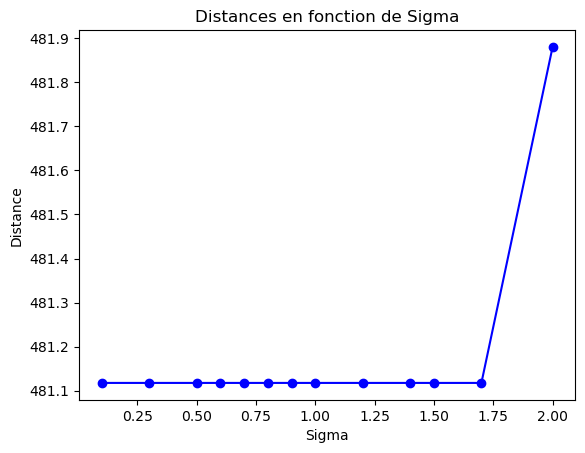

Le meilleur alignement est : 

Distance moyenne =  481.1177008631807
Sigma =  0.1
K = 
 [[1.00000000e+00 2.68678177e-14 5.65214626e-12 ... 1.58791839e-26
  3.10661426e-11 1.13943879e-15]
 [2.68678177e-14 1.00000000e+00 2.00600289e-15 ... 4.95956592e-33
  5.21092685e-14 3.42503015e-16]
 [5.65214626e-12 2.00600289e-15 1.00000000e+00 ... 9.28396771e-09
  3.73146661e-06 4.28342763e-04]
 ...
 [1.58791839e-26 4.95956592e-33 9.28396771e-09 ... 1.00000000e+00
  6.82820541e-16 6.10016732e-10]
 [3.10661426e-11 5.21092685e-14 3.73146661e-06 ... 6.82820541e-16
  1.00000000e+00 8.86330041e-07]
 [1.13943879e-15 3.42503015e-16 4.28342763e-04 ... 6.10016732e-10
  8.86330041e-07 1.00000000e+00]]


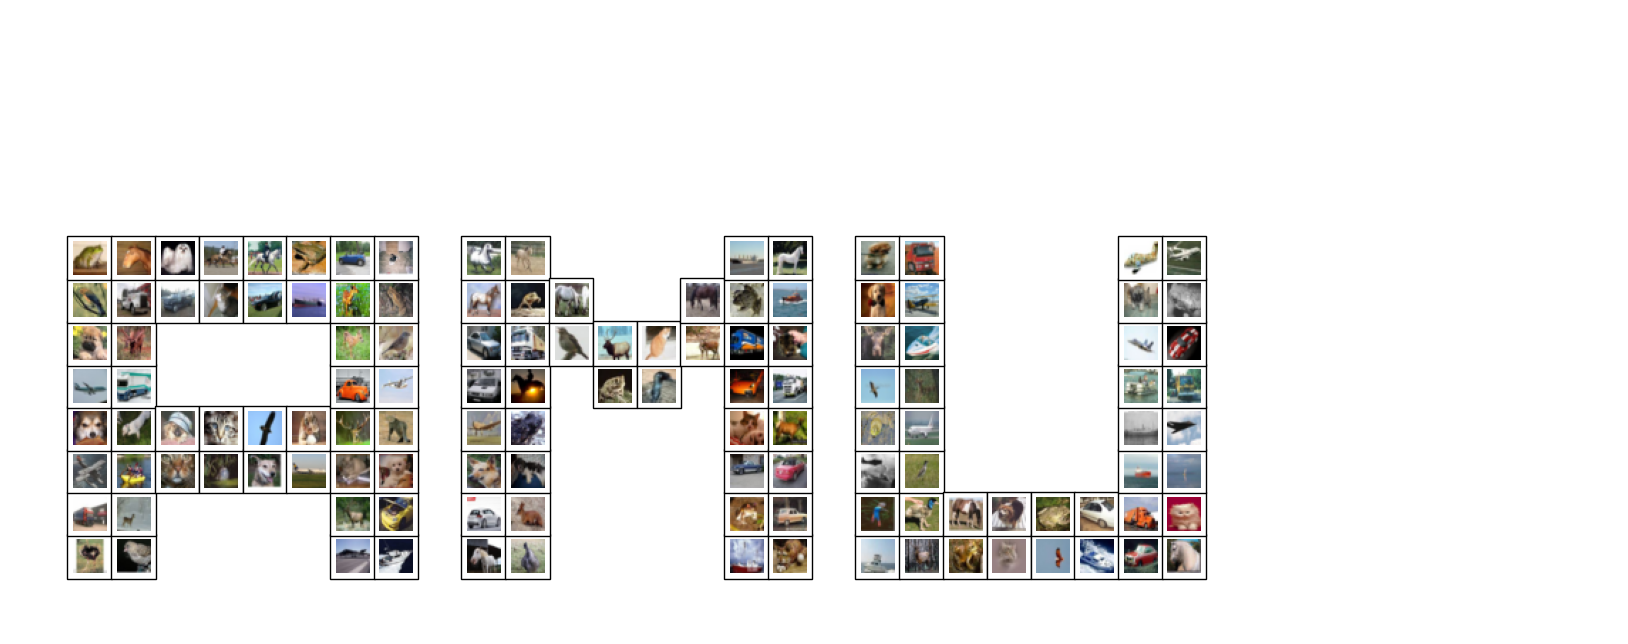

In [17]:
v_sigma = [.1, .3, .5, .6, .7, .8, .9, 1, 1.2, 1.4, 1.5, 1.7, 2]
#v_sigma = [.1, .3, .5, .6, .7, .8, .9, 1, 1.2, 1.4, 1.5]
#v_sigma = [1]
dists = []
grids = []
imgs_sorted = []

for s in v_sigma:
    imgdata_sorted, grid, K, dist_mean = test_to_evaluate(s)
    imgs_sorted.append(imgdata_sorted)
    grids.append(grid)
    dists.append(dist_mean)

plt.plot(v_sigma, dists, 'bo-')
plt.xlabel('Sigma')
plt.ylabel('Distance')
plt.title('Distances en fonction de Sigma')
plt.show()

print("Le meilleur alignement est : \n")
print("Distance moyenne = ", min(dists))
print("Sigma = ", v_sigma[dists.index(min(dists))])
print("K = \n", K)
display(imgs_sorted[dists.index(min(dists))], grids[dists.index(min(dists))])